In [7]:
using ImagePhantoms
using ImageGeoms: ImageGeom, axesf
using MIRT
using MIRTjim
using Plots
using FFTW
using Random
using LinearMapsAA
using LinearAlgebra

Here, we simulate the data with CAIPI+ACS sampling

In [8]:
# set simulated data parameters
N = 32; # nominal 2d matrix size (diameter)
fov = 20; # field of view (cm)
nl = 0.1; # noise level
nc = 8; # number of simulated coils
N_acs = 8; # ACS region (diameter of fully sampled region)
Rx_caipi = 3; # CAIPI kx acceleration factor (outside ACS region, per frame)
Ry_caipi = 2; # CAIPI ky acceleration factor (outside ACS region, per frame)
Δ_caipi = 1; # CAIPI odd/even shift

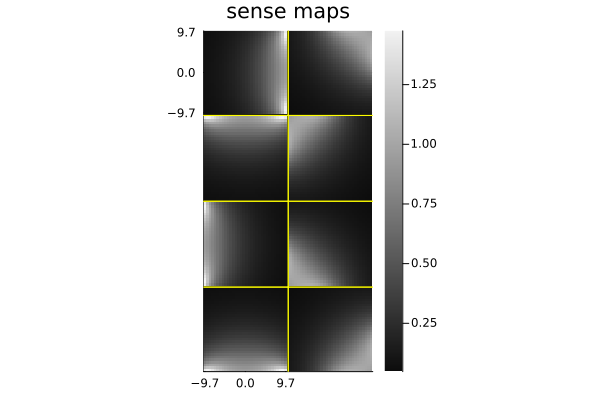

In [9]:
# simulate the object
ig = ImageGeom(dims=(N,N), deltas=(fov/N,fov/N));
objects = shepp_logan(SheppLoganToft(); fovs=(fov,fov));
ρ_true = phantom(axes(ig)..., objects); # shepp logan phantom

# simulate the sensitivity maps
smaps = ir_mri_sensemap_sim(dims=(N,N), dx=fov/N, dy=fov/N, rcoil=10, ncoil=nc);

jim(axes(ig), ρ_true, title="true object");
jim(axes(ig), smaps, title="sense maps")

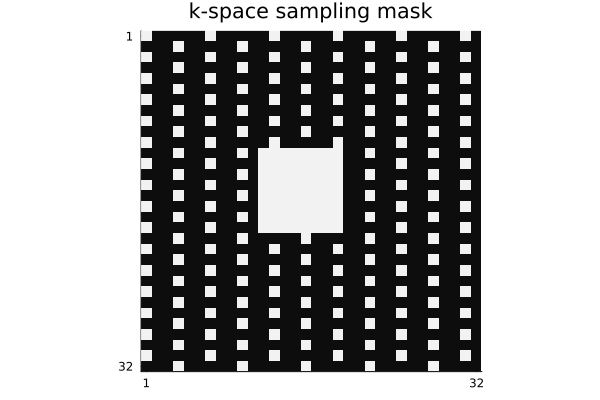

In [10]:
# initialize mask
msk = zeros(Int, (N, N));

# set ACS region in mask
idx_acs = round.(Int, N/2 .+ (-N_acs/2:N_acs/2-1)); # central ACS indices
for x in idx_acs, y in idx_acs
    msk[x, y] = 1
end

# set Rx by Ry CAIPI sampling indicies
for x in 1:Rx_caipi:N
    y_shift = Δ_caipi * floor(Int, (x-1)/Rx_caipi);
    for y in mod.((0:Ry_caipi:N-1) .+ y_shift, N) .+ 1
        msk[x, y] = 1
    end
end

jim(msk; title="k-space sampling mask", colorbar=false)

In [11]:
# create forward fourier encoding operator
F = LinearMapAA(
    x -> fftshift(fft(x)) .* msk,
    y -> ifft(ifftshift(msk .* y)),
    (N^2, N^2);
    T=ComplexF64,
    idim=(N,N),
    odim=(N,N)
);

# create sensitivity encoding operator
S = vcat([LinearMapAA(diagm(smaps[:,:,i][:]); idim=(N,N), odim=(N,N)) for i=1:nc] ...);

# construct full forward model
A = kron(I(nc), F) * S;

In [12]:
# simulate the data via inverse crime
Ɛ = nl*(randn(N,N,nc) .+ 1im*randn(N,N,nc)) .* msk; # acquired noise
kdata = A*ρ_true + Ɛ;

In [13]:
# save kdata to mat file
#using MAT
#matwrite("/mnt/storage/djfrey/for_David_PISCO_3D/kdata.mat", Dict("kdata" => kdata))

Next, we will estimate the SENSE maps using PISCO

In [14]:
# set PISCO parameters
τ = Int(3); # neighborhood size (radius)
kernel_shape = 1; # (0 for rect, 1 for circle)
pad = 1; # (option to pad the patch shift locations)
α_win = 100; # gaussian window parameter
N_acs = 16; # size of calibration region
interp_zp = 24; # interpolation outside the ACS region
d = 50; # sketch dimension (overestimate the rank of PhP here)
σ_thresh = 0.002; # threshold for singular values

In [15]:
# create some helper functions
even_RL = x -> Int(1 - mod(x, 2.0)); # helps with using odd data points

# gaussian window function (reflects matlab gausswin.m)
function gausswin(N,α)
    L = N-1;
    n = (0:L) .- L/2;
    return exp.(-0.5 * (α * n / (L/2)).^2);
end

# function to generate grid points
function grid(xs::AbstractVector...)
    nd = length(xs)
    N = prod(length.(xs))
    xgrd = zeros(eltype(xs[1]), N, nd)
    for d in 1:nd
        shape = ntuple(j -> j == d ? length(xs[d]) : 1, nd)
        rep = ntuple(j -> j == d ? 1 : length(xs[d]), nd)
        xgrd[:, d] = repeat(reshape(xs[d], shape), rep...)[:]
    end
    return xgrd
end

grid (generic function with 1 method)

In [16]:
# get parameters
nd = ndims(kdata)-1; # number of image dimensions
N = size(kdata)[1:nd]; # image size
Q = size(kdata, nd+1); # number of channels
N_cal = N_acs*ones(Int,nd);

# get aliased image
idata = ifft(ifftshift(kdata,1:nd),1:nd);

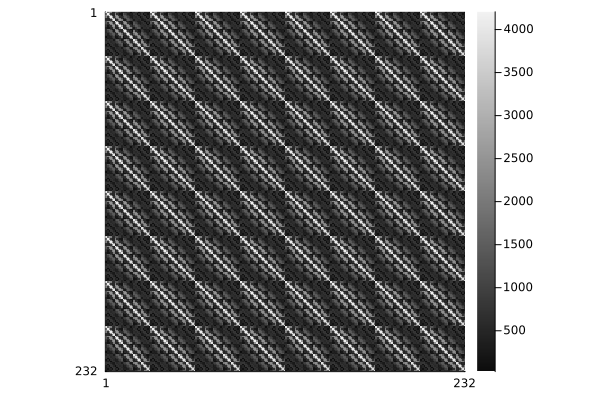

In [ ]:
# get calibration data
cal_idcs = [ceil.(Int,N[d]/2) + even_RL(N[d]/2) .+ (-floor(Int,N_cal[d]/2):floor(Int,N_cal[d]/2)-even_RL(N_cal[d]/2)) for d in 1:nd];
kcal = kdata[cal_idcs..., :];

# create neighborhood grid points
Λ_idcs = grid([-τ:τ for d in 1:nd]...);

# mask out edges if using circular kernel
if kernel_shape == 1
    cmask = vec(sum(Λ_idcs.^2, dims=2)) .<= τ^2;
    Λ_idcs = Λ_idcs[cmask,:];
end

# get patch size
Λ_len = size(Λ_idcs,1);

# form the convolution matrix
C = zeros(ComplexF64, prod(N_cal .- 2*τ .- even_RL.(N_cal)), Λ_len, Q)
k = grid(ntuple(d -> τ+1+even_RL(N_cal[d]):N_cal[d]-τ, nd)...); # grid of shift points
for i in 1:size(k,1)
    idcs = ntuple(d -> k[i, d] .+ Λ_idcs[:, d], nd); # shifted indicies
    C[i,:,:] .= getindex.(Ref(kcal), idcs..., Q);
end
C = reshape(C, (prod(N_cal .- 2*τ .- even_RL.(N_cal)), Λ_len*Q)); # reshape

In [18]:
# take the SVD of C to find its null space
(~,σ,V) = svd(C);
r = count(σ/σ[1] .> σ_thresh);
V0 = V[:, r:end]; # get the null space basis of C
P = size(V0, 2); # number of null space basis vectors

# ft the filters to the image domain
f_p = zeros(ComplexF64, P, Q, N...);
for i in 1:Λ_len
    f_p[:, :, [Int(N[d]/2) + Λ_idcs[i,d] for d in 1:nd]...] .= reshape(conj.(V0'), P, Λ_len, Q)[:,i,:];
end
h_p = ifft(ifftshift(f_p, 3:nd+2));

MethodError: MethodError: no method matching svd(::Array{ComplexF64, 3})

Closest candidates are:
  svd(!Matched::BitMatrix)
   @ LinearAlgebra ~/.julia/juliaup/julia-1.10.5+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/bitarray.jl:90
  svd(!Matched::Bidiagonal; kw...)
   @ LinearAlgebra ~/.julia/juliaup/julia-1.10.5+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/bidiag.jl:244
  svd(!Matched::Diagonal{T, V} where V<:AbstractVector{T}) where T<:Number
   @ LinearAlgebra ~/.julia/juliaup/julia-1.10.5+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/diagonal.jl:810
  ...


In [19]:
# form H matrix
H = reshape(h_p,P,Q,prod(N));

# estimate sensitivity maps
smaps_est = zeros(ComplexF64, Q, prod(N));
for x in 1:prod(N) # loop through vo/pixels
    # estimate sensitivity at x as last null space vector of H(x)
    (~,~,V) = svd(H[:,:,x]);
    smaps_est[:,x] = V[:,end];
end
smaps_est = permutedims(reshape(smaps_est, Q, N...),((2:nd+1)...,1));

UndefVarError: UndefVarError: `h_p` not defined

In [20]:
plot(
    jim(axes(ig), smaps, title="true sensitivity maps"),
    jim(axes(ig), smaps_est, title="estimated sensitivity maps"),
    layout=(1,2))

UndefVarError: UndefVarError: `smaps_est` not defined